In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import association_metrics as am
from scipy.stats import f_oneway

import polars as pl

Predict the age of abalone from physical measurements

- Sex - nominal - M, F, and I (infant)
- Length - continuous - mm - Longest shell measurement
- Diameter - continuous - mm - perpendicular to length
- Height - continuous - mm - with meat in shell
- Whole weight - continuous - grams - whole abalone
- Shucked weight - continuous - grams - weight of meat
- Viscera weight - continuous - grams - gut weight (after bleeding)
- Shell weight - continuous - grams - after being dried
- Rings - integer - +1.5 gives the age in years (target)

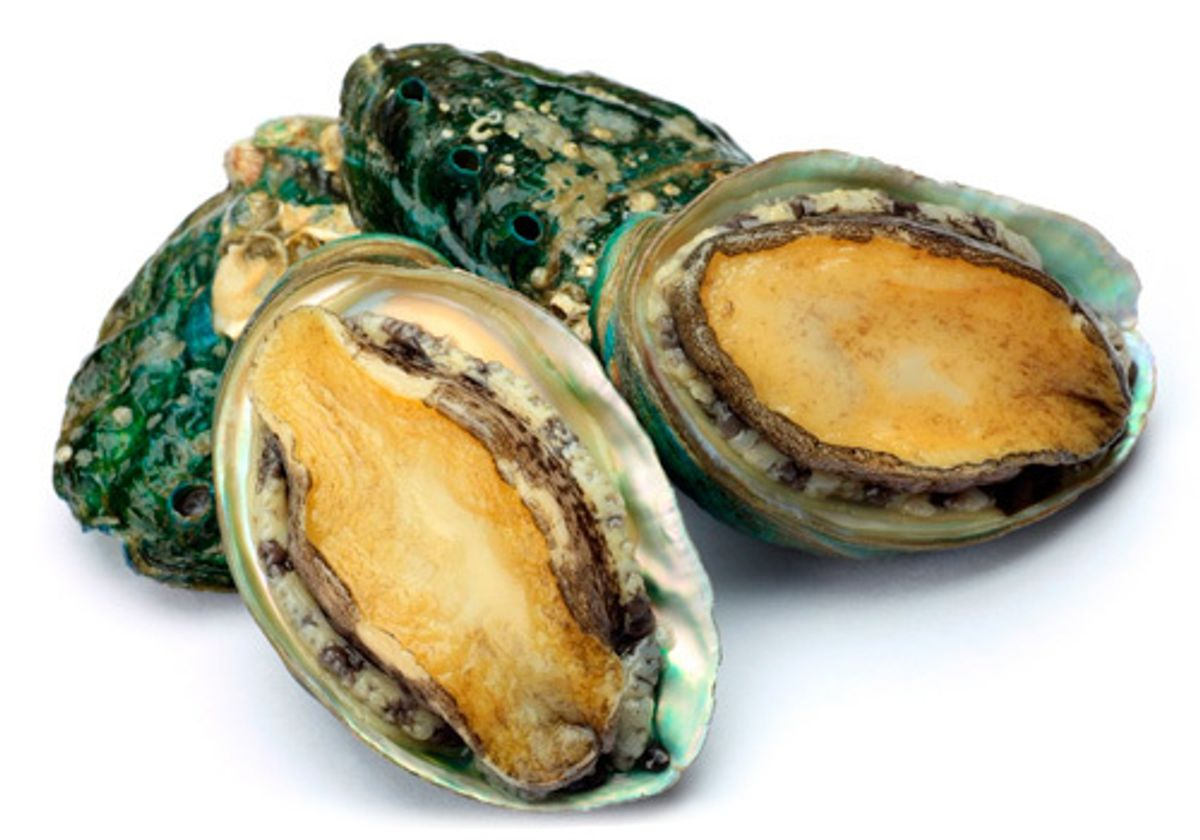

### Общее исследование данных: проверим размеры таблицы, число столбцов, количество пропусков в столбцах

In [11]:
df = pd.read_csv("abalone.csv")
print(df.shape)
df.head(-5)

(4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4167,M,0.500,0.380,0.125,0.5770,0.2690,0.1265,0.1535,9
4168,F,0.515,0.400,0.125,0.6150,0.2865,0.1230,0.1765,8
4169,M,0.520,0.385,0.165,0.7910,0.3750,0.1800,0.1815,10
4170,M,0.550,0.430,0.130,0.8395,0.3155,0.1955,0.2405,10


Набор данных имеет 9 признаков и состоит из 4177 строки

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4078 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4078 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4127 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


8 признаков из имеющихся представляют собой числовые значения и один признак - категориальный

In [15]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4078.000000,4177.000000,4078.000000,4177.000000,4177.000000,4127.000000,4177.000000
mean,0.523992,0.407840,0.139516,0.827306,0.359367,0.180594,0.239072,9.933684
std,0.120093,0.099286,0.041827,0.490348,0.221963,0.109614,0.138942,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.440500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.798500,0.336000,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.150875,0.502000,0.253000,0.328250,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [20]:
df.isnull().mean() * 100

Sex               0.000000
Length            0.000000
Diameter          2.370122
Height            0.000000
Whole weight      2.370122
Shucked weight    0.000000
Viscera weight    0.000000
Shell weight      1.197031
Rings             0.000000
dtype: float64

В исходном датасете имеются пропуски по функциям 'Diameter', 'Whole weight', 'Shell weight'. Так как объем пропусков не значительный (до 2.4%), то заполним пропуски медианным значением

In [48]:
median_diameter = df['Diameter'].median()
print(median_diameter)
median_weight_1 = df['Whole weight'].median()
print(median_weight_1)
median_weight_2 = df['Shell weight'].median()
print(median_weight_2)

df.fillna({'Diameter': median_diameter, 'Whole weight': median_weight_1, 'Shell weight': median_weight_2}, inplace=True)
df['age'] = df['Rings'].apply(lambda x: x + 1.5)
df.isnull().mean() * 100

0.425
0.7985
0.235


Sex               0.0
Length            0.0
Diameter          0.0
Height            0.0
Whole weight      0.0
Shucked weight    0.0
Viscera weight    0.0
Shell weight      0.0
Rings             0.0
age               0.0
dtype: float64

### Однофакторный анализ: по каждому столбцу посмотрим его распределение. Изучим связи с целевой переменной

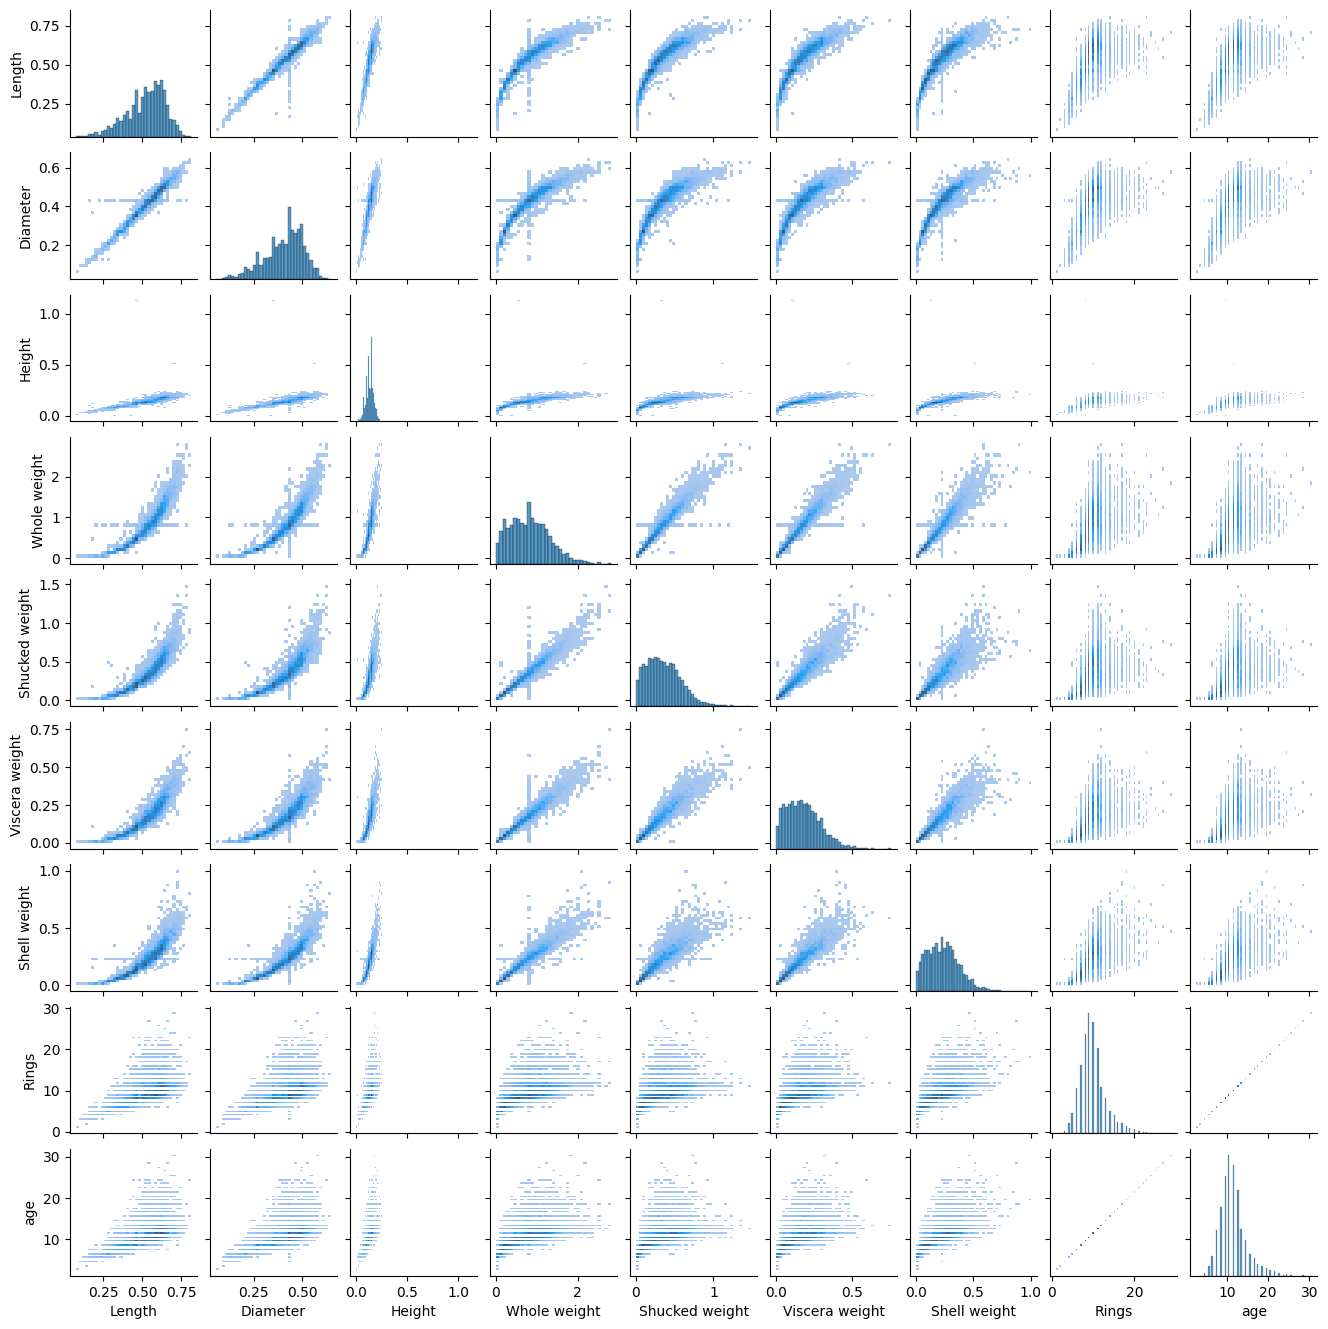

In [50]:
sns.pairplot(df, kind = 'hist', height=1.5, aspect=1)

Распределение целевой функции 'age' является одномодальным (имеет один пик) и является лог-нормальным. Распределение имеет хвост справа, что может свидетельствовать о наличии выбросов.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Так же взаимосвязи между числовыми признаками возможно оценить с использованием матрицы корреляций. Используем методику Пирсона, для определения степени линейной взаимосвязи между числовыми колонками нашего датафрейма.

<Axes: >

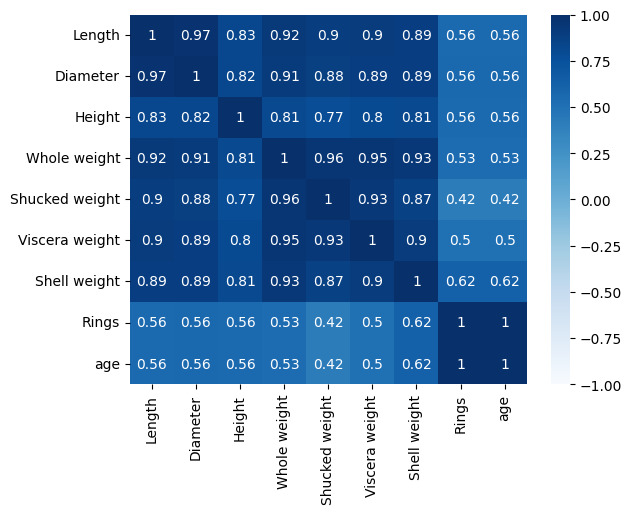

In [51]:
corr = df.corr(numeric_only=True, method='pearson')
sns.heatmap(corr, cmap="Blues", annot=True, vmin=-1, vmax=1)

<Axes: >

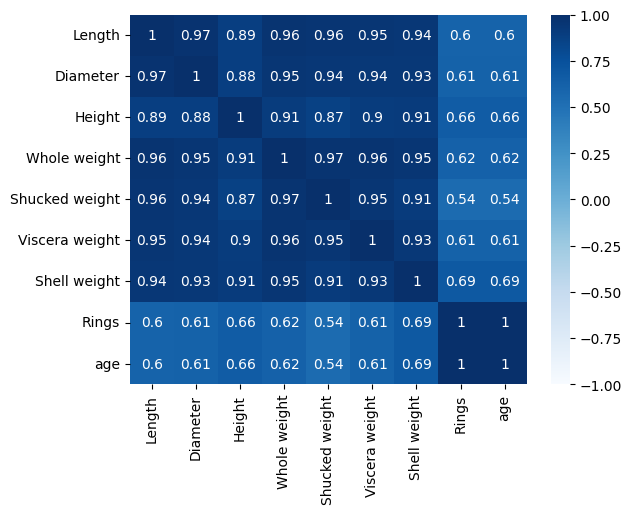

In [77]:
corr = df.corr(numeric_only=True, method='spearman')
sns.heatmap(corr, cmap="Blues", annot=True, vmin=-1, vmax=1)

Все размерные и весовые характеристики имеют положительную корреляцию с целевой функцией. Что является логичным, чем старше становятся молюски тем они больше весят и увеличиваются в размерах.

Рассмотрим категориальную функцию 'Sex' и ее связи с остальными параметрами датасета

In [54]:
print(df.Sex.unique())
df['Sex'] = df['Sex'].replace('f', 'F')
print(df.Sex.unique())

['M' 'F' 'I' 'f']
['M' 'F' 'I']


Для оценки распределения признаков возраста и размеров от пола особей построим барплоты.

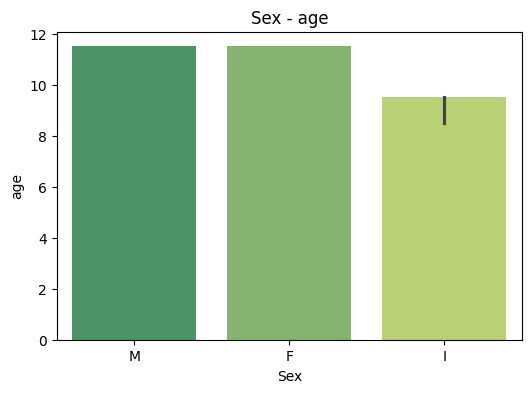

In [68]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='age', hue='Sex', data=df, palette='summer', estimator="median", dodge=False) 
plt.title('Sex - age')
plt.show()


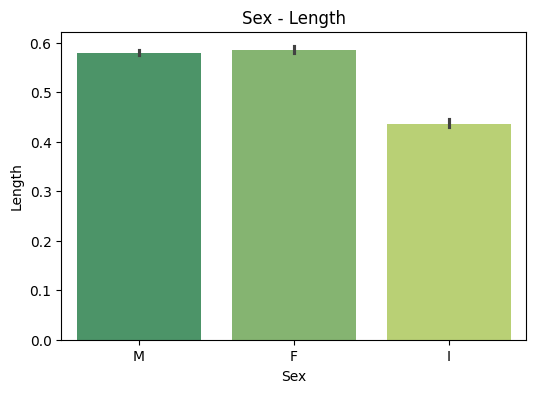

In [65]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Length', hue='Sex', data=df, palette='summer', estimator="median", dodge=False) 
plt.title('Sex - Length')
plt.show()

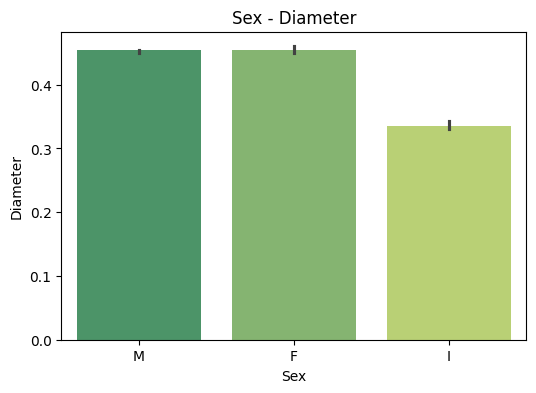

In [71]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Diameter', hue='Sex', data=df, palette='summer', estimator="median", dodge=False) 
plt.title('Sex - Diameter')
plt.show()

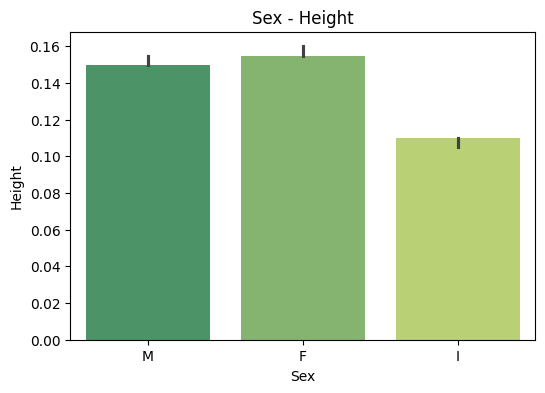

In [72]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Height', hue='Sex', data=df, palette='summer', estimator="median", dodge=False) 
plt.title('Sex - Height')
plt.show()

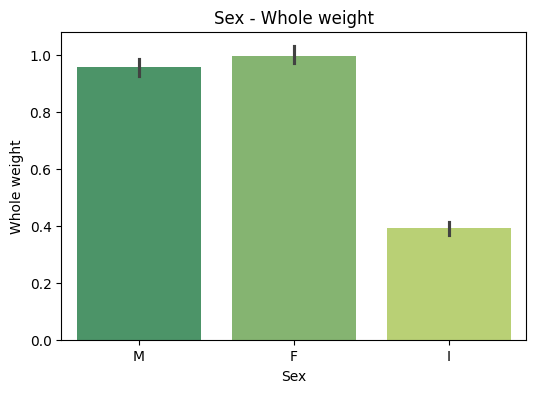

In [73]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sex', y='Whole weight', hue='Sex', data=df, palette='summer', estimator="median", dodge=False) 
plt.title('Sex - Whole weight')
plt.show()

In [96]:
age_stats = df.groupby('Sex')['age'].agg(['mean', 'median', 'count'])
age_stats

,mean,median,count
Sex,,,
F,12.501376,11.5,1454
I,9.372257,9.5,1276
M,12.178645,11.5,1447


Видно, что взрослые молюски категории F имеют такие же диаметри и длину, что и категории M, но при этом обладают большим весом и высотой раковины, что может быть косвенным признаком, что молюсков женского пола жемчуг появляется чаще, чем у взрослых особей мужского пола. Хотя это и не является определяющим фактором и может быть лишь спецификой подобранного датасета.

In [84]:
Data = []

for c1 in df.columns:
    for c2 in df.columns:
        if df[c1].dtype == 'object' and df[c2].dtype != 'object':
            CategoryGroupLists = df.groupby(c1)[c2].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            if AnovaResults[1] >= 0.05:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'No', 'Value': AnovaResults[1]})
            else:
                Data.append({'Category' : c1, 'Numerical' : c2, 'Is correlated' : 'Yes', 'Value': AnovaResults[1]})

AnovaRes = pd.DataFrame.from_dict(Data)
AnovaRes

,Category,Numerical,Is correlated,Value
0,Sex,Length,Yes,8.366338e-308
1,Sex,Diameter,Yes,1.711956e-315
2,Sex,Height,Yes,1.109013e-265
3,Sex,Whole weight,Yes,1.378586e-303
4,Sex,Shucked weight,Yes,1.502737e-267
5,Sex,Viscera weight,Yes,5.442072e-312
6,Sex,Shell weight,Yes,1.558861e-294
7,Sex,Rings,Yes,2.353039e-182
8,Sex,age,Yes,2.353039e-182


По результатам ANOVA (англ. Analysis of Variance) видим, что категориальная функция 'Sex' коррелирует со всеми числовыми признаками, включая целефую функцию. Рассмотрим взаимосвязи между данными сагрегированными по признаку 'Sex'

<Axes: >

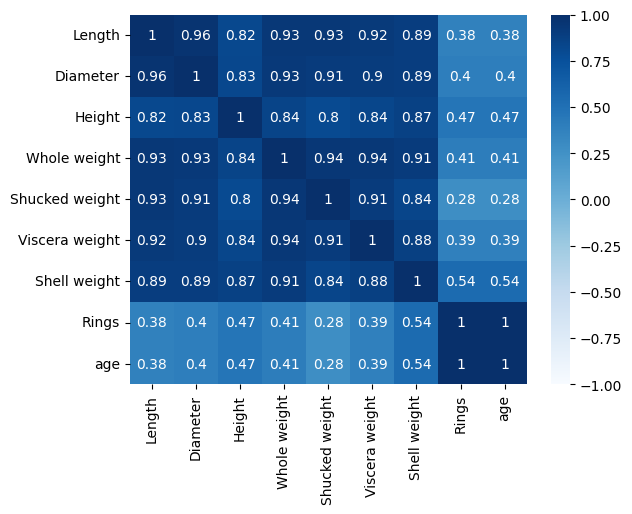

In [78]:
corr = df[df.Sex == 'M'].corr(numeric_only=True, method='spearman')
sns.heatmap(corr, cmap="Blues", annot=True, vmin=-1, vmax=1)

<Axes: >

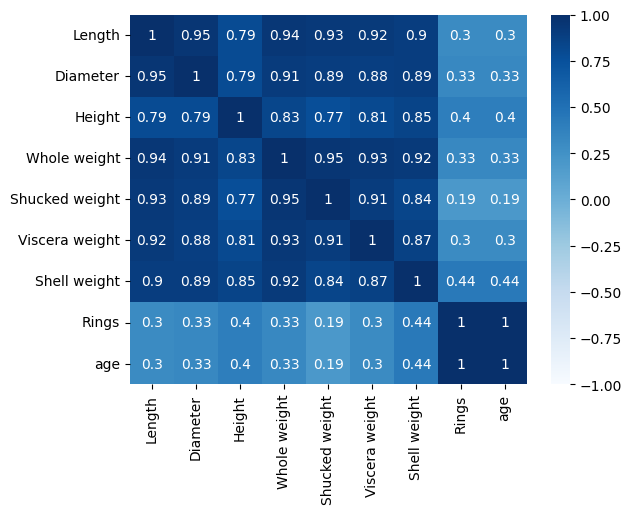

In [79]:
corr = df[df.Sex == 'F'].corr(numeric_only=True, method='spearman')
sns.heatmap(corr, cmap="Blues", annot=True, vmin=-1, vmax=1)

<Axes: >

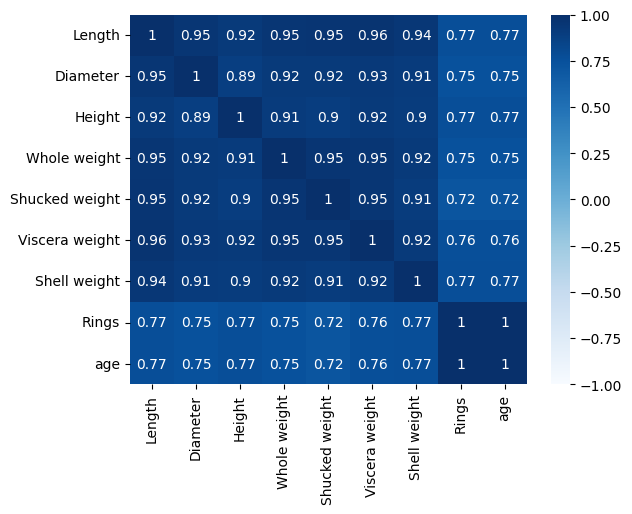

In [81]:
corr = df[df.Sex == 'I'].corr(numeric_only=True, method='spearman')
sns.heatmap(corr, cmap="Blues", annot=True, vmin=-1, vmax=1)

In [82]:
df['Sex'].value_counts(normalize=True)*100

Sex
F    34.809672
M    34.642088
I    30.548240
Name: proportion, dtype: float64

Мы видим, что степень корреляции веса и размера от возраста меняется от полового признака при примерно одинаковом распределении значений по категориям 'Sex'. Так наибольшие значения степени корреляции наблюдаются у абалонов категории I (infant). При этом само распределение абалонов по категориям 'Sex' больше зависит от размеров и веса.  

# Изучение библиотеки polars и анализ ее производительности в стравнении с pandas

Увеличим размер датасета и применим библиотеку polars. Исходный набор данных содержит 4177 строк, значит для создания датафрейма в 1.000.000 строк нужно выполнить дублирование не менее 239 раз.

In [92]:
df_big = df.copy()

for i in range(239):
  df_big = pd.concat([df_big, df])

df_big.to_csv("abalone_big.csv", index=False)

In [93]:
%%time

df_pl = pl.read_csv("abalone_big.csv")
df_pl.shape

CPU times: total: 688 ms
Wall time: 96.7 ms


(1002480, 10)

Рассмотрим сколько долю особей старше медианного возраста обоих полов

In [100]:
%%time

(len(df_pl.filter(pl.col('age') > 11.5))/len(df_pl['Sex'] != 'I'))*100


CPU times: total: 0 ns
Wall time: 13 ms


34.64208762269572

35% долгожителей среди взрослых особей

In [111]:
%%time

df_pl.group_by('age').agg([pl.mean('Length'),
                        pl.mean('Diameter'),
                        pl.mean('Height'),
                        pl.max('Whole weight'
                        )]).sort('age')

CPU times: total: 46.9 ms
Wall time: 41.9 ms


age,Length,Diameter,Height,Whole weight
f64,f64,f64,f64,f64
2.5,0.075,0.055,0.01,0.002
3.5,0.15,0.1,0.025,0.015
4.5,0.176,0.149,0.041667,0.0665
5.5,0.221491,0.173158,0.053947,0.196
6.5,0.285739,0.219783,0.069913,0.7985
…,…,…,…,…
25.5,0.695,0.54,0.2,1.978
26.5,0.645,0.49,0.215,1.406
27.5,0.6,0.495,0.195,1.0575
